# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import shutil
import glob
import json
import collections
import tensorflow as tf
import numpy as np
import librosa
import random
from scipy.stats import entropy

import tensorflow.keras
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from IPython.display import Audio, Image, display_jpeg, display

# Define Functions

In [4]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [5]:
def get_image_features(model, filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_image(x)
    preds = model.predict(x)[0]
    return preds

In [6]:
def get_sound_features(model,filepath):
    x, sr = librosa.load(filepath)
    x = x * 255.0
    x = np.reshape(x, (1, x.shape[0], 1, 1))
    x[x < -255.] = -255.
    x[x > 255.] = 255.
    assert np.max(x) < 256., "It seems this audio contains signal that exceeds 256"
    assert np.min(x) > -256., "It seems this audio contains signal that exceeds -256 " + str(np.min(x)) + " : " + filepath
    _y_pred = model.predict(x)
    feature =  _y_pred[0][0][0][0]
    return feature

In [7]:
def get_topk_songs(img_feature, song_features, k=3):
    distances = []
    for i in range(len(song_features)):
        distance = entropy(img_feature, song_features[i])
        distances.append(distance)
    topk_indecies = np.argsort(distances)[:k]
    return topk_indecies

In [8]:
def create_sound_libs(
    soundnet_model,
    query="sound_samples/*.mp3",
    out_json_path="sounds.json",
    out_npy_path='song_features.npy'
):
    mp3_files = glob.glob(query)
    output_dict = {"mp3":[]}
    for i in range(len(mp3_files)):
        x, sr = librosa.load(mp3_files[i])
        if len(x) > 230000:
            output_dict["mp3"].append({"filepath":mp3_files[i], "index":str(i)})
    with open(out_json_path, "w")  as f:
        json.dump(output_dict, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    song_features = []
    for item in output_dict["mp3"]:
        i_feature = get_sound_features(soundnet_model,item['filepath'])
        song_features.append(i_feature)
    song_features = np.array(song_features)
    print("Sound npy shape:", song_features.shape)
    np.save(out_npy_path, song_features)
    return (output_dict, song_features)

# Load SoundNet and ImageNet models

In [3]:
soundnet = load_model("soundnet.hdf5")
imagenet = MobileNet(include_top=True, weights='imagenet') # using MobileNet

# Create sound features using SoundNet model

In [10]:
# create sound features using SoundNet model
(mp3_files, sound_features) = create_sound_libs(soundnet)

print ("268 of mp3 files", len(mp3_files['mp3']))

Sound npy shape: (268, 1000)
268 of mp3 files


In [13]:
# or, load pre-processed json data
with open("sounds.json") as f:
    mp3_files = json.load(f)
sound_features = np.load("song_features.npy")

# Generate the best-matched sound files for an input image

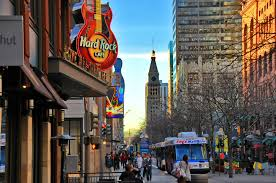

In [30]:
IMG_PATH = "image_samples/town.jpg"
display_jpeg(Image(IMG_PATH))

In [31]:
# Extract image features using ImageNet model(MobileNet)
img_feature = get_image_features(imagenet, IMG_PATH)

# Match the image features and pre-processed sound features,
# then find the topK best matched sound files 
topk_indecies = get_topk_songs(img_feature, sound_features, k=3)

In [33]:
print("The best-matched sound:")
for i in range(3):
    print('Top#',i)
    a=mp3_files["mp3"][topk_indecies[i]]["filepath"]
    display(Audio(None,a[7:]))

The best-matched sound:
Top# 0


Top# 1


Top# 2
